In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [5]:
tf.reset_default_graph()

In [6]:
#Loading the MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
np.random.seed(42)
tf.set_random_seed(42)

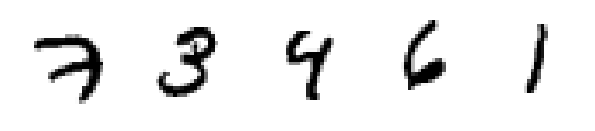

In [8]:
#Visualizing the dataset
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [9]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

In [10]:
#Input Layer for the images
X = tf.placeholder(shape=[None,28,28,1], dtype = tf.float32, name= "X")
#None for batch_size

In [11]:
#Primary Capsule Layer
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps*6*6 #1152 primary capsule units
caps1_n_dims = 8


In [12]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [13]:
conv1 = tf.layers.conv2d(X, name = 'conv1', **conv1_params)
conv2 = tf.layers.conv2d(conv1, name = "conv2", **conv2_params)


In [14]:
conv2

<tf.Tensor 'conv2/Relu:0' shape=(?, 6, 6, 256) dtype=float32>

In [15]:
# Shape of Output of conv2: (batch_size, 6, 6, 32, 8) 
# Since this first capsule layer will be fully connected to the next capsule layer, we can simply flatten the 6×6 grids
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims], name = 'caps1_raw')


In [16]:
def squash(s, axis=-1, epsilon = 1e-7, name=None):
    with tf.name_scope(name, default_name = 'squash'):
        squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keep_dims=True)
        safe_norm = tf.sqrt(squared_norm+epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor*unit_vector

In [17]:
caps1_output = squash(caps1_raw, name="caps1_output")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [18]:
#Digit Caps
caps2_n_caps = 10
caps2_n_dims = 16

In [19]:
W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=0.1, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

In [20]:
raw_weights

NameError: name 'raw_weights' is not defined

In [21]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [22]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

In [23]:
W_tiled


<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

In [24]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

In [25]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

In [26]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [27]:
#Dynamic Routing
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

In [28]:
routing_weights = tf.nn.softmax(raw_weights, axis=2, name="routing_weights")


In [29]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

In [30]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [31]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [32]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [33]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

In [34]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

In [35]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

In [36]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

Instructions for updating:
dim is deprecated, use axis instead


In [37]:
caps2_output = caps2_output_round_2

In [38]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [39]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

In [40]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

In [41]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(?, 1, 1) dtype=int64>

In [42]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

In [43]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

In [44]:
#Loss function
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [45]:
T = tf.one_hot(y, depth = caps2_n_caps, name = "T")

In [46]:
with tf.Session() as sess:
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [47]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True, name = "caps2_output_norm")
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

In [48]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

In [49]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

In [50]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

In [51]:
#Reconstruction
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

In [52]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

In [53]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>

In [54]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

In [55]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [56]:
caps2_output_masked


<tf.Tensor 'caps2_output_masked:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [57]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

In [58]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

In [59]:
#Decoder
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28*28

In [60]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

In [61]:
#Reconstrustion loss
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

In [62]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

In [63]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [64]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name = 'training_op')

In [65]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [66]:
#Training
n_epochs = 10
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val
            

Epoch: 1  Val accuracy: 98.8000%  Loss: 0.016379 (improved)
Epoch: 2  Val accuracy: 99.2600%  Loss: 0.009912 (improved)
Iteration: 172/1100 (15.6%)  Loss: 0.00335

KeyboardInterrupt: 

In [67]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final test accuracy: 99.2500%  Loss: 0.009454   


## Output Vector Analysis

In [70]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


In [71]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

In [72]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

In [73]:
tweak_labels = np.tile(mnist.test.labels[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


In [74]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])

Tweaking output dimension #0


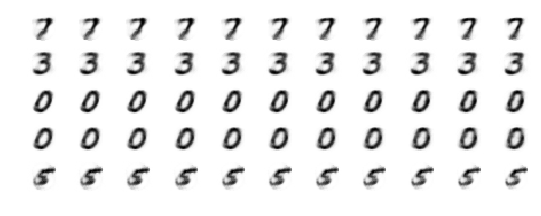

Tweaking output dimension #1


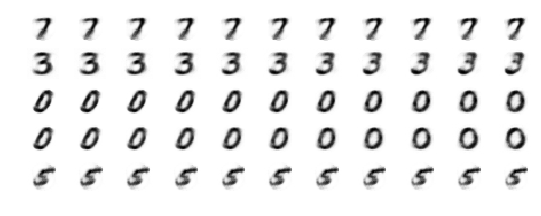

Tweaking output dimension #2


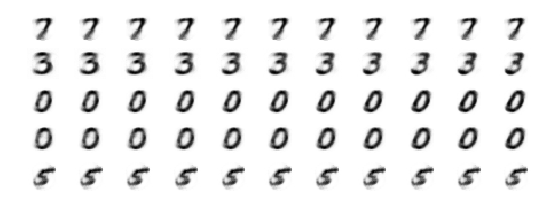

In [75]:
for dim in range(3):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()